In [2]:
import pandas as pd
import numpy as np
import joblib
from flask import Flask, request, render_template
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load the Dataset


In [3]:
import pandas as pd

df = pd.read_csv('recipe_dataset.csv')

df.head()

,Unnamed: 0,recipe_id,recipe_name,aver_rate,image_url,review_nums,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,ingredients_list
0,0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,15,36,1,42,21,81,2,"['pork belly', 'smoked paprika', 'kosher salt'..."
1,1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,19,18,10,73,33,104,41,"['sauerkraut drained', 'Granny Smith apples sl..."
2,2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,17,36,2,48,24,31,4,"['chicken wings', 'sprigs rosemary', 'head gar..."
3,3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,32,45,20,65,20,43,18,"['focaccia bread quartered', 'prepared basil p..."
4,4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,8,12,5,14,7,8,3,"['red potatoes', 'strips bacon', 'Sauce:', 'he..."


In [4]:
df['recipe_id'] = df.index

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,recipe_id,recipe_name,aver_rate,image_url,review_nums,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,ingredients_list
0,0,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,15,36,1,42,21,81,2,"['pork belly', 'smoked paprika', 'kosher salt'..."
1,1,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,19,18,10,73,33,104,41,"['sauerkraut drained', 'Granny Smith apples sl..."
2,2,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,17,36,2,48,24,31,4,"['chicken wings', 'sprigs rosemary', 'head gar..."
3,3,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,32,45,20,65,20,43,18,"['focaccia bread quartered', 'prepared basil p..."
4,4,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,8,12,5,14,7,8,3,"['red potatoes', 'strips bacon', 'Sauce:', 'he..."


In [6]:
# === Preprocessing ===
vectorizer = TfidfVectorizer(max_features=1000)
X_ingredients = vectorizer.fit_transform(df['ingredients_list'])
scaler = StandardScaler()
X_nutrition = scaler.fit_transform(df[['calories', 'fat', 'carbohydrates', 'protein', 'cholesterol', 'sodium', 'fiber']])
X_combined = np.hstack([X_nutrition, X_ingredients.toarray()])

## KNN

In [7]:
# === KNN ===
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X_combined)

NearestNeighbors()

## KMeans

In [8]:
# === KMeans ===
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_combined)
df['cluster'] = kmeans.predict(X_combined)

## Neural Networks

In [9]:
input_dim = X_combined.shape[1]  # Input dimension based on X_combined
input_layer = Input(shape=(input_dim,))
x = Dense(256, activation='relu')(input_layer)
x = Dense(128, activation='relu')(x)
x = Dense(1007, activation='linear')(x)  # Output layer should match input dimension
ff_model = Model(inputs=input_layer, outputs=x)
ff_model.compile(optimizer=Adam(1e-3), loss='mse')
ff_model.fit(X_combined, X_combined, epochs=5, batch_size=64, verbose=0)

recipe_embeddings = ff_model.predict(X_combined)

1523/1523 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


#### Evaluation

In [10]:
# === Evaluation & Recommendation ===
def evaluate(input_vec, rec_vecs):
    cosine_sim = cosine_similarity(input_vec, rec_vecs).flatten()
    return cosine_sim.mean()

#### Recommendations

In [11]:
def get_recommendations(model_name, input_features):
    nutrition = scaler.transform([input_features[:7]])
    ingredients = vectorizer.transform([input_features[7]])
    input_combined = np.hstack([nutrition, ingredients.toarray()])

    if model_name == 'KNN':
        dists, indices = knn.kneighbors(input_combined)
        results = df.iloc[indices[0]]
        sims = evaluate(input_combined, X_combined[indices[0]])
    elif model_name == 'KMeans':
        cluster = kmeans.predict(input_combined)[0]
        results = df[df['cluster'] == cluster].head(5)
        indices = results.index
        sims = evaluate(input_combined, X_combined[indices])
    elif model_name == 'FFNN':
        embedding = ff_model.predict(input_combined)
        sims_all = cosine_similarity(embedding, recipe_embeddings).flatten()
        indices = sims_all.argsort()[-5:][::-1]
        results = df.iloc[indices]
        sims = sims_all[indices].mean()
    else:
        results, sims = pd.DataFrame(), 0

    return results[['recipe_name', 'ingredients_list']].to_dict(orient='records'), sims

#### Best Model

In [12]:
# Sample input features: 7 nutritional values + ingredient string
input_sample = [15, 36, 1, 42, 21, 81, 2, 'pork belly, smoked paprika, kosher salt']

# List of model names to evaluate
models = ['KNN', 'KMeans', 'FFNN']

# Store similarity scores
scores = {}
recommendations = {}

for model in models:
    recs, sim_score = get_recommendations(model, input_sample)
    scores[model] = sim_score
    recommendations[model] = recs  # Optional: view recommended recipes

print("Similarity Scores for Each Model:")
for model, score in scores.items():
    print(f"{model}: {score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


e:\Deep Learning\Deep_Learning_2024\Recipe Recommendation\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
e:\Deep Learning\Deep_Learning_2024\Recipe Recommendation\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
e:\Deep Learning\Deep_Learning_2024\Recipe Recommendation\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Similarity Scores for Each Model:
KNN: 0.8287
KMeans: 0.4388
FFNN: 0.9576


In [14]:
import matplotlib.pyplot as plt

scores_df = pd.DataFrame(scores, index=['cosine Similarity']).T
scores_df

,cosine Similarity
KNN,0.828653
KMeans,0.438788
FFNN,0.957609


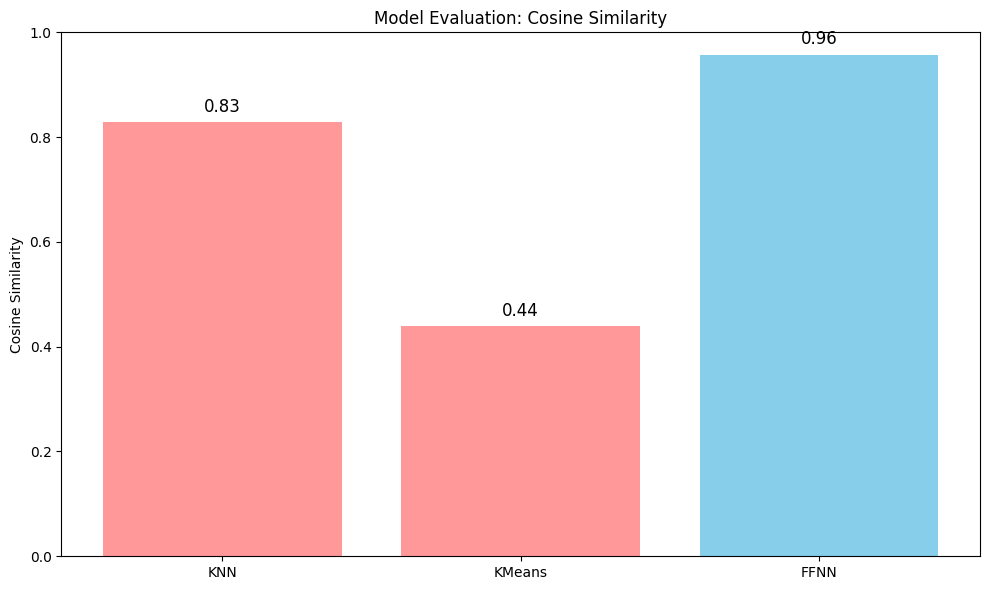

In [34]:
import matplotlib.pyplot as plt

# Extract model names and their similarity values
models = scores_df.index.tolist()
similarities = scores_df['cosine Similarity'].tolist()

# Define custom colors — blue only for FFNN
colors = ['#FF9999' if model != 'FFNN' else 'skyblue' for model in models]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, similarities, color=colors)

# Labels and title
plt.ylabel('Cosine Similarity')
plt.title('Model Evaluation: Cosine Similarity')
plt.ylim(0, 1)

# Annotate values above bars
for bar, value in zip(bars, similarities):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.02, f"{value:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


#### Saving Best Model

In [35]:
ff_model.save('recipe_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']